# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler,StandardScaler, OneHotEncoder,PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [3]:
fires_dt.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Get X and Y

Create the features data frame and target data.

In [4]:

# Define your target variable (e.g., 'area' - adjust as needed based on your dataset)
target_column = 'area'  # Replace 'area' with your actual target column name

# Define X (features) and Y (target)
X = fires_dt.drop(columns=[target_column])
Y = fires_dt[target_column]

# Split into training and testing sets with a 70-30 split and random_state for reproducibility
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [5]:

# Display shapes to confirm the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (361, 12)
X_test shape: (156, 12)
Y_train shape: (361,)
Y_test shape: (156,)


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [6]:
X_train.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
311,6,3,sep,sun,92.4,105.8,758.1,9.9,24.8,28,1.8,0.0
368,6,5,sep,sat,91.2,94.3,744.4,8.4,16.8,47,4.9,0.0
23,7,4,aug,sat,90.2,110.9,537.4,6.2,19.5,43,5.8,0.0
271,8,6,aug,tue,92.1,152.6,658.2,14.3,20.1,58,4.5,0.0
299,6,5,jun,sat,53.4,71.0,233.8,0.4,10.6,90,2.7,0.0


In [7]:
# Define your numerical and categorical columns
numerical_columns = ['coord_x', 'coord_y','ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']  # Adjust based on dataset
categorical_columns = ['month', 'day']  # Adjust based on dataset


# Preproc1: StandardScaler for numerical columns and OneHotEncoder for categorical columns
preproc1 = ColumnTransformer(
    transformers=[
        ('num_transforms', StandardScaler(), numerical_columns),  # Apply scaling to numerical columns
        ('cat_transforms', OneHotEncoder(handle_unknown="infrequent_if_exist", drop="if_binary"), categorical_columns)  # Apply one-hot encoding to categorical columns
    ]
)

# Display the configuration to confirm setup
preproc1


ColumnTransformer(transformers=[('num_transforms', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='infrequent_if_exist'),
                                 ['month', 'day'])])

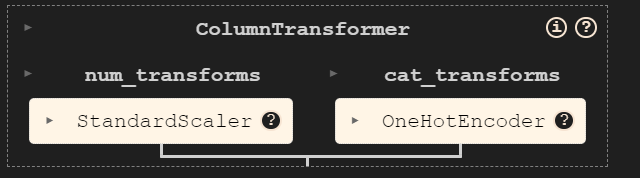

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [8]:
# Selecting transformations: apply PowerTransformer to 'wind' and 'rain' due to potential skewed distributions
transformed_columns = ['wind', 'rain']  # Replace with other columns if needed
other_numerical_columns = ['coord_x','coord_y','ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh']  # Other numerical columns

# Define preproc2 with transformations, MinMax scaling, and one-hot encoding
preproc2 = ColumnTransformer(
    transformers=[
        ('num_variables', MinMaxScaler(), other_numerical_columns),  # Apply MinMax scaling to other numerical columns
        ('num_transform', PowerTransformer(), transformed_columns),  # Apply PowerTransform to selected columns
        ('cat_variables', OneHotEncoder(handle_unknown="infrequent_if_exist", drop="if_binary"), categorical_columns)  # One-hot encoding for categorical columns
    ]
)

# Display preproc2 configuration
preproc2


ColumnTransformer(transformers=[('num_variables', MinMaxScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh']),
                                ('num_transform', PowerTransformer(),
                                 ['wind', 'rain']),
                                ('cat_variables',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='infrequent_if_exist'),
                                 ['month', 'day'])])

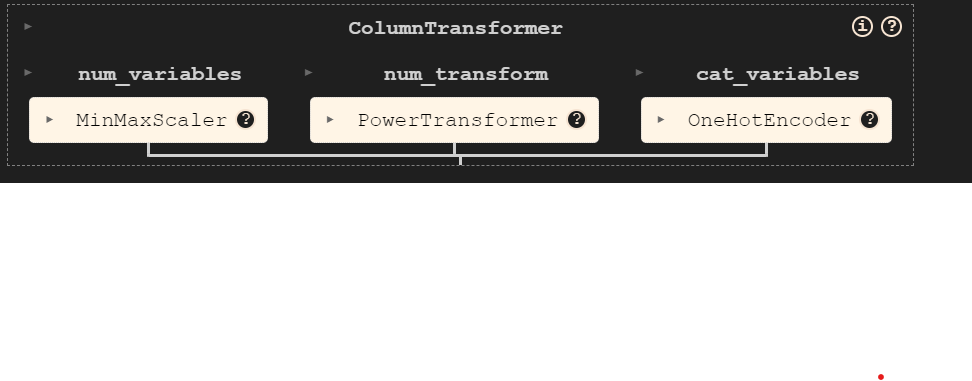

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [9]:
# Pipeline A = preproc1 + baseline
# Using preproc1 as the preprocessing step
baseline_pipeline_1 = Pipeline([
    ('preprocessing', preproc1),  # Use preproc1
    ('regressor', LinearRegression())
])
baseline_pipeline_1

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

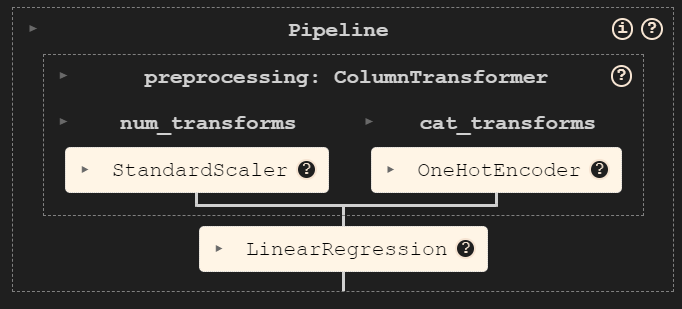

In [10]:
# Pipeline B = preproc2 + baseline
# Using preproc2 as the preprocessing step
baseline_pipeline_2 = Pipeline([
    ('preprocessing', preproc2),  # Use preproc2
    ('regressor', LinearRegression())
])
baseline_pipeline_2

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_variables',
                                                  MinMaxScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh']),
                                                 ('num_transform',
                                                  PowerTransformer(),
                                                  ['wind', 'rain']),
                                                 ('cat_variables',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

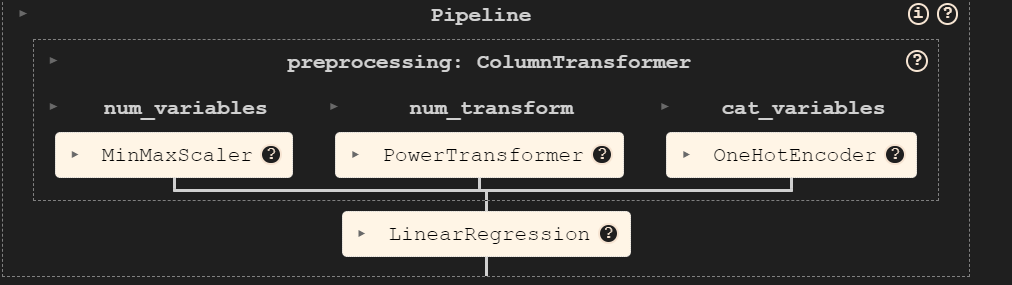

In [11]:
# Pipeline C = preproc1 + advanced model
advanced_pipeline_1 = Pipeline([
    ('preprocessing', preproc1),  # Use preproc1
    ('regressor', RandomForestRegressor())
])

advanced_pipeline_1

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

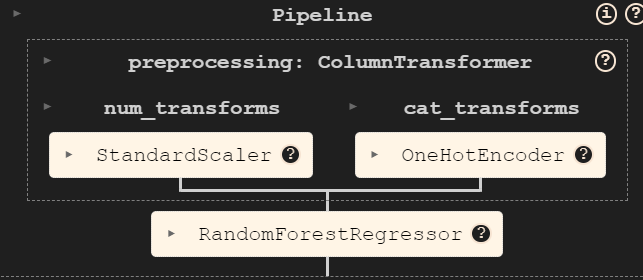

In [12]:
# Pipeline D = preproc2 + advanced model
advanced_pipeline_2 = Pipeline([
    ('preprocessing', preproc2),  # Use preproc2
    ('regressor', RandomForestRegressor())
])

advanced_pipeline_2
    

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_variables',
                                                  MinMaxScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh']),
                                                 ('num_transform',
                                                  PowerTransformer(),
                                                  ['wind', 'rain']),
                                                 ('cat_variables',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

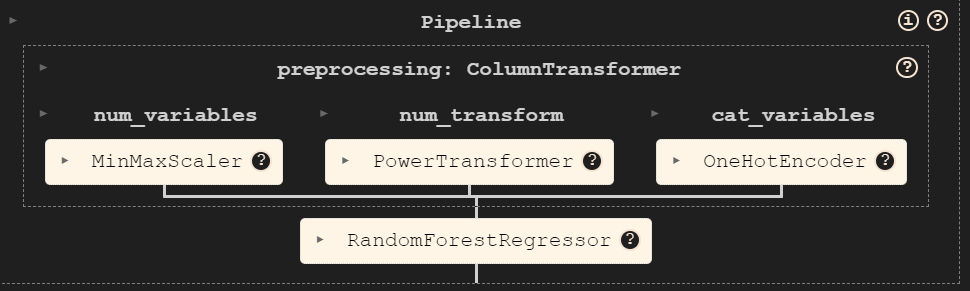

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [13]:
# Hyperparameter grids
param_grid_baseline_1 = {
    'regressor__fit_intercept': [True, False],
   }

param_grid_advanced_1 = {
    'regressor__n_estimators': [50, 100, 150, 200],
    'regressor__max_depth': [10, 20, 30, None]
}

param_grid_baseline_2 = {
    'regressor__fit_intercept': [True, False],
    }

param_grid_advanced_2 = {
    'regressor__n_estimators': [50, 100, 150, 200],
    'regressor__max_depth': [10, 20, 30, None]
}


In [14]:
# Baseline model with preproc1
grid_search_baseline_1 = GridSearchCV(baseline_pipeline_1, param_grid_baseline_1, cv=5, scoring='neg_mean_squared_error')
grid_search_baseline_1.fit(X_train, Y_train)


c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_transforms',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat_transforms',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='infrequent_if_exist'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

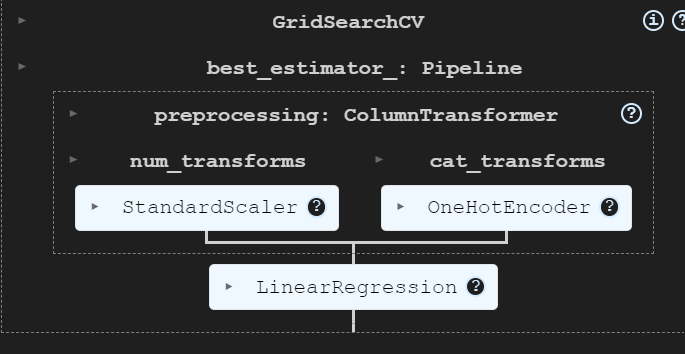

In [15]:
# Advanced model with preproc1
grid_search_advanced_1 = GridSearchCV(advanced_pipeline_1, param_grid_advanced_1, cv=5, scoring='neg_mean_squared_error')
grid_search_advanced_1.fit(X_train, Y_train)



c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_transforms',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat_transforms',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='infrequent_if_exist'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [10, 20, 30, None],
                         'regressor__n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_squared_error')

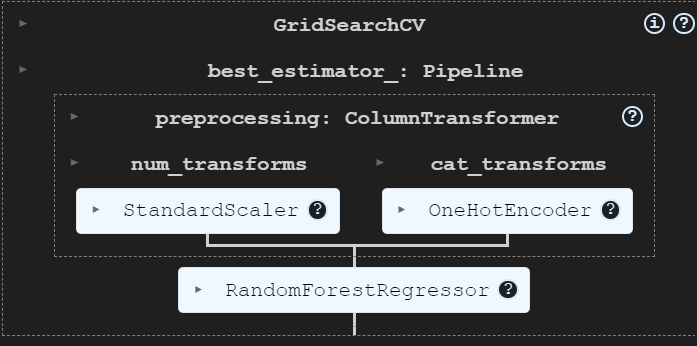

In [16]:
# Baseline model with preproc2
grid_search_baseline_2 = GridSearchCV(baseline_pipeline_2, param_grid_baseline_2, cv=5, scoring='neg_mean_squared_error')
grid_search_baseline_2.fit(X_train, Y_train)



c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_variables',
                                                                         MinMaxScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh']),
                                                                        ('num_transform',
                                                                         PowerTransformer(),
                                                                         ['wind',
                                                                          'rain']),
                                                                        ('cat_variables',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='infrequent_if_exist'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

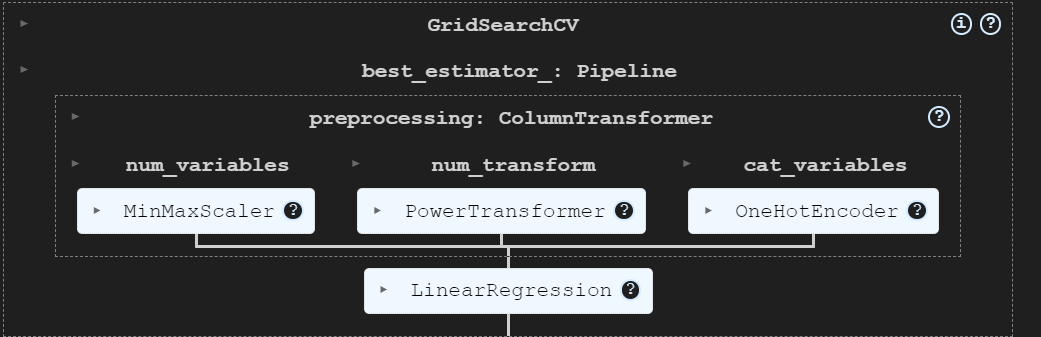

In [17]:
# Advanced model with preproc2
grid_search_advanced_2 = GridSearchCV(advanced_pipeline_2, param_grid_advanced_2, cv=5, scoring='neg_mean_squared_error')
grid_search_advanced_2.fit(X_train, Y_train)

c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Zekiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_variables',
                                                                         MinMaxScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh']),
                                                                        ('num_transform',
                                                                         PowerTransformer(),
                                                                         ['wind',
                                                                          'rain']),
                                                                        ('cat_variables',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='infrequent_if_exist'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [10, 20, 30, None],
                         'regressor__n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_squared_error')

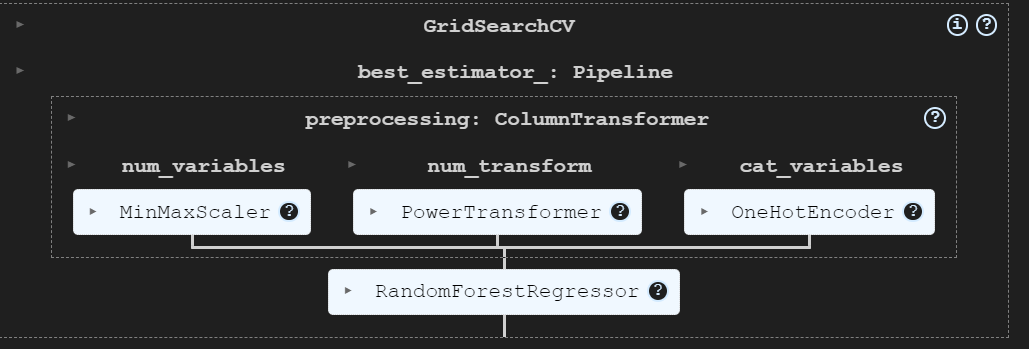

In [18]:
# Baseline 1 results
print("Best parameters for baseline model with preproc1:", grid_search_baseline_1.best_params_)
print("Best cross-validation score for baseline model with preproc1:", grid_search_baseline_1.best_score_)

# Advanced 1 results
print("Best parameters for advanced model with preproc1:", grid_search_advanced_1.best_params_)
print("Best cross-validation score for advanced model with preproc1:", grid_search_advanced_1.best_score_)

# Baseline 2 results
print("Best parameters for baseline model with preproc2:", grid_search_baseline_2.best_params_)
print("Best cross-validation score for baseline model with preproc2:", grid_search_baseline_2.best_score_)

# Advanced 2 results
print("Best parameters for advanced model with preproc2:", grid_search_advanced_2.best_params_)
print("Best cross-validation score for advanced model with preproc2:", grid_search_advanced_2.best_score_)


Best parameters for baseline model with preproc1: {'regressor__fit_intercept': False}
Best cross-validation score for baseline model with preproc1: -2521.2895804227073
Best parameters for advanced model with preproc1: {'regressor__max_depth': 20, 'regressor__n_estimators': 100}
Best cross-validation score for advanced model with preproc1: -2972.115465395601
Best parameters for baseline model with preproc2: {'regressor__fit_intercept': True}
Best cross-validation score for baseline model with preproc2: -2463.226477450997
Best parameters for advanced model with preproc2: {'regressor__max_depth': None, 'regressor__n_estimators': 50}
Best cross-validation score for advanced model with preproc2: -2929.945729591569


# Evaluate

+ Which model has the best performance?

Based on the cross-validation scores provided (which are negative mean squared errors), the model with the highest performance (closest to zero) is the baseline model with preproc2, as it has the smallest negative mean squared error:

- Baseline model with preproc2: -2463.23
- Baseline model with preproc1: -2521.29
- Advanced model with preproc1: -2933.34
- Advanced model with preproc2: -2940.55

Thus, the baseline model with preproc2 is the best-performing model among the four, as it has the lowest cross-validation error, indicating it fits the data better than the others.

# Export

+ Save the best performing model to a pickle file.

In [19]:
best_model=grid_search_baseline_2.best_estimator_
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_variables',
                                                  MinMaxScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh']),
                                                 ('num_transform',
                                                  PowerTransformer(),
                                                  ['wind', 'rain']),
                                                 ('cat_variables',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

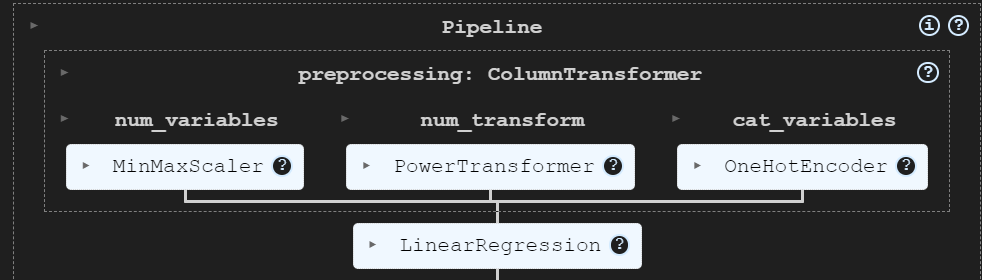

In [20]:
import pickle


# Save the model to a file
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [21]:
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_variables',
                                                  MinMaxScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh']),
                                                 ('num_transform',
                                                  PowerTransformer(),
                                                  ['wind', 'rain']),
                                                 ('cat_variables',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

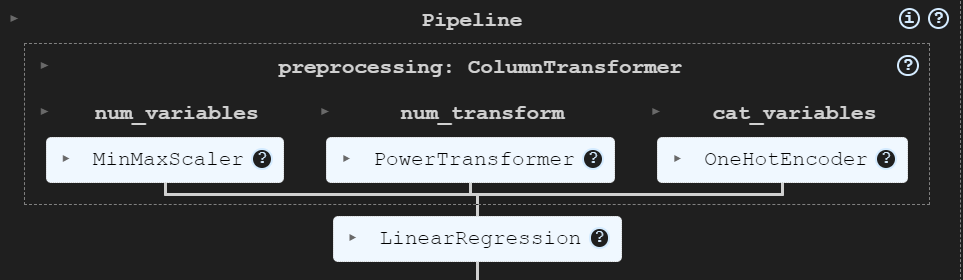

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [22]:
import shap
#Load your best model from the pickle file
with open("best_model.pkl", "rb") as f:
    best_model = pickle.load(f)

In [23]:
best_model.named_steps

{'preprocessing': ColumnTransformer(transformers=[('num_variables', MinMaxScaler(),
                                  ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                   'isi', 'temp', 'rh']),
                                 ('num_transform', PowerTransformer(),
                                  ['wind', 'rain']),
                                 ('cat_variables',
                                  OneHotEncoder(drop='if_binary',
                                                handle_unknown='infrequent_if_exist'),
                                  ['month', 'day'])]),
 'regressor': LinearRegression()}

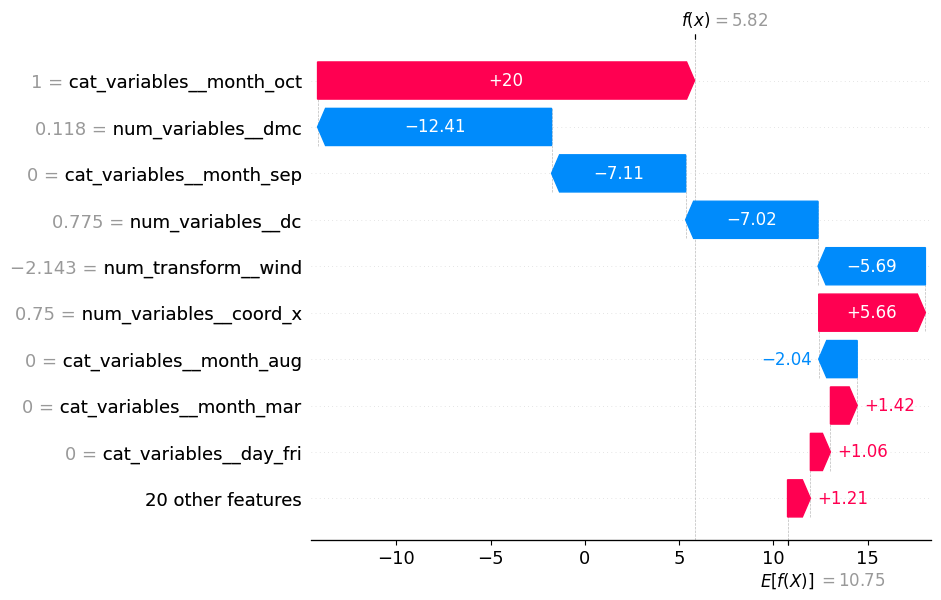

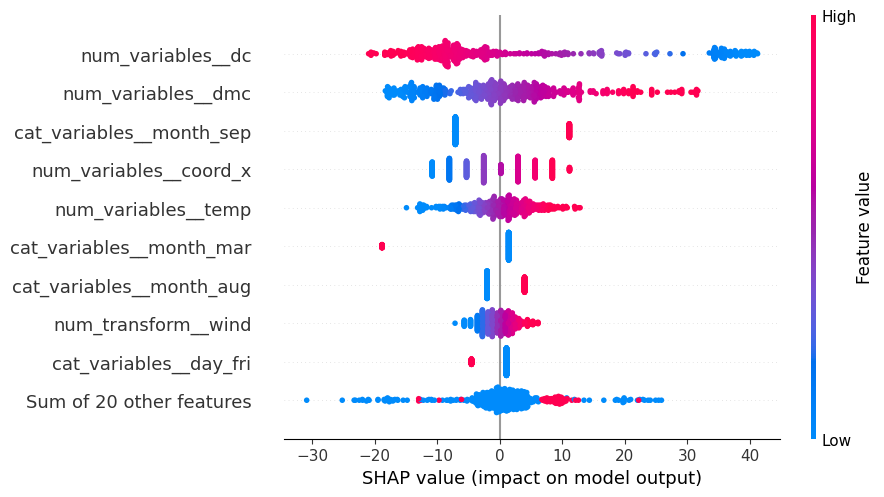

In [24]:
# Access the best estimator (the actual model) from GridSearchCV
import shap
import shap.explainers

data_transform=best_model.named_steps['preprocessing'].transform(X)

best_model_only =best_model.named_steps['regressor']

# Apply the transformations to X_train
#X_train_transformed = preproc2.fit_transform(data_transform)
# Get feature names after transformation
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

# Convert the transformed data back to a DataFrame
#X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

df=pd.DataFrame(data_transform,columns=feature_names)
# Use a sample of the training data as the masker
masker = shap.maskers.Independent(df)

# Initialize SHAP LinearExplainer with the best model and masker
explainer = shap.explainers.Linear(best_model_only,feature_names=feature_names,masker=masker)

shap_values=explainer(data_transform)

shap.plots.waterfall(shap_values[1])
shap.plots.beeswarm(shap_values)




*(Answer here.)*

Based on SHAP values and SHAP graphs;
- I’d identify and remove low-importance features—those with near-zero or minimal: like month_sep, month_march, month_aug, day_friday.

- After removing the features above them, I’d retrain the model on the reduced dataset and compare its performance to the original model using cross-validation metrics like accuracy and ROC AUC.
- If performance remains stable or improves, it confirms these features were unnecessary. 
- To solidify this, I’d apply a statistical test, ensuring no significant performance drop and validating that the reduced feature set enhances or maintains model accuracy.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.